<a href="https://colab.research.google.com/github/konks/meta/blob/main/Conv2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchsummary import summary
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class Meta(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        weights = torch.randn((self.size_in, self.size_out))
        self.weights = nn.Parameter(weights)
        self.soft = nn.Softmax(0)

    def forward(self, x):
        x = x.matmul(self.soft(self.weights))
        return x

In [ ]:
class MyNet(nn.Module):
  def __init__(self):
    super(MyNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(2048, 40)
    self.fc2 = nn.Linear(40, 10)


  def forward(self, x):
    x = F.mish(self.conv1(x))
    x = self.pool(F.mish(self.conv2(x)))
    x = self.pool(F.mish(self.conv3(x)))
    x = torch.flatten(x, 1)
    x = F.mish(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
from tqdm import tqdm_notebook
import torch.optim as optim

net = MyNet().to(device)

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
losses = []

In [ ]:
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
            Conv2d-2           [-1, 16, 32, 32]             880
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
         MaxPool2d-5             [-1, 32, 8, 8]               0
            Linear-6                   [-1, 40]          81,960
            Linear-7                   [-1, 10]             410
Total params: 88,058
Trainable params: 88,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.28
Params size (MB): 0.34
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[1,    50] loss: 2.101
[1,   100] loss: 1.770
[1,   150] loss: 1.607
[1,   200] loss: 1.538
[1,   250] loss: 1.451
[1,   300] loss: 1.389
[1,   350] loss: 1.390


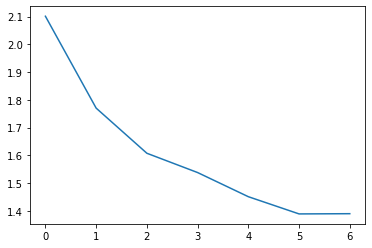

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[2,    50] loss: 1.260
[2,   100] loss: 1.239
[2,   150] loss: 1.224
[2,   200] loss: 1.199
[2,   250] loss: 1.161
[2,   300] loss: 1.181
[2,   350] loss: 1.131


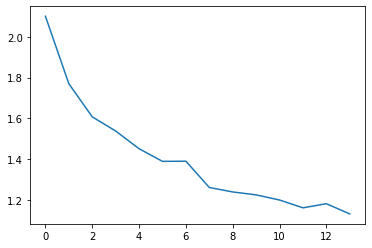

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[3,    50] loss: 1.058
[3,   100] loss: 1.058
[3,   150] loss: 1.040
[3,   200] loss: 1.049
[3,   250] loss: 1.026
[3,   300] loss: 1.003
[3,   350] loss: 0.995


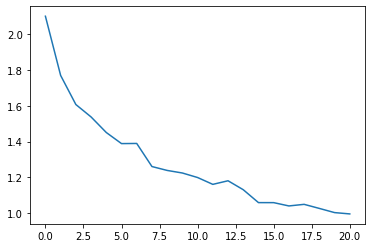

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[4,    50] loss: 0.934
[4,   100] loss: 0.933
[4,   150] loss: 0.904
[4,   200] loss: 0.924
[4,   250] loss: 0.921
[4,   300] loss: 0.910
[4,   350] loss: 0.922


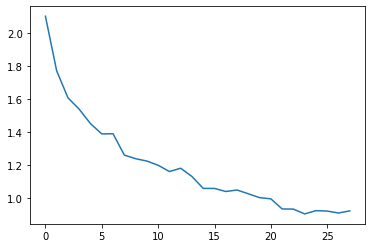

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[5,    50] loss: 0.837
[5,   100] loss: 0.827
[5,   150] loss: 0.836
[5,   200] loss: 0.818
[5,   250] loss: 0.827
[5,   300] loss: 0.847
[5,   350] loss: 0.830


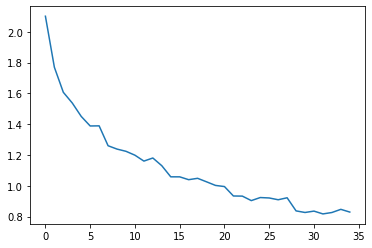

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[6,    50] loss: 0.754
[6,   100] loss: 0.757
[6,   150] loss: 0.745
[6,   200] loss: 0.774
[6,   250] loss: 0.765
[6,   300] loss: 0.769
[6,   350] loss: 0.770


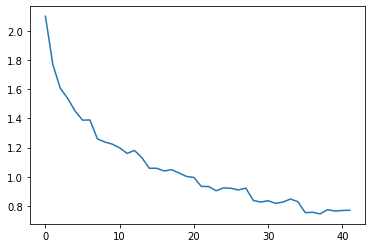

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[7,    50] loss: 0.663
[7,   100] loss: 0.682
[7,   150] loss: 0.695
[7,   200] loss: 0.702
[7,   250] loss: 0.713
[7,   300] loss: 0.725
[7,   350] loss: 0.719


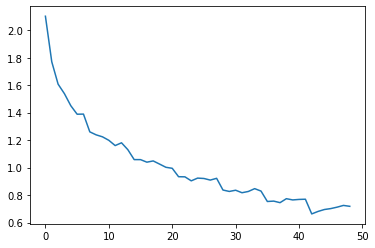

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[8,    50] loss: 0.624
[8,   100] loss: 0.617
[8,   150] loss: 0.632
[8,   200] loss: 0.670
[8,   250] loss: 0.652
[8,   300] loss: 0.648
[8,   350] loss: 0.653


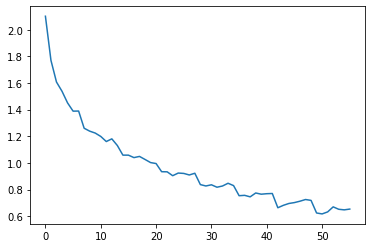

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[9,    50] loss: 0.552
[9,   100] loss: 0.578
[9,   150] loss: 0.570
[9,   200] loss: 0.591
[9,   250] loss: 0.613
[9,   300] loss: 0.616
[9,   350] loss: 0.615


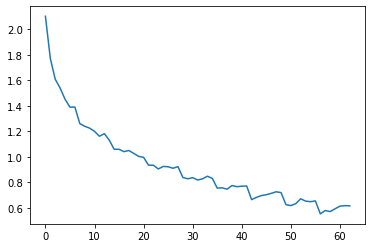

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/391 [00:00<?, ?it/s]

[10,    50] loss: 0.530
[10,   100] loss: 0.535
[10,   150] loss: 0.511
[10,   200] loss: 0.547
[10,   250] loss: 0.563
[10,   300] loss: 0.563
[10,   350] loss: 0.566


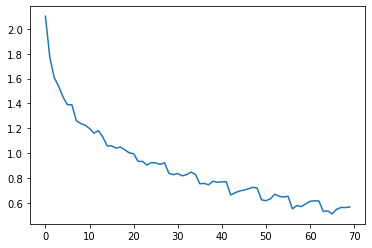

Обучение завершено


In [ ]:
for epoch in tqdm_notebook(range(10)):

  running_loss = 0.0
  for i, batch in enumerate(tqdm_notebook(trainloader)): #занумеровали batch (кортеж из 4 изображений и 4 ответов)
    
    X_batch, y_batch = batch

    optimizer.zero_grad()

    y_pred = net(X_batch.to(device))
    loss = loss_fn(y_pred, y_batch.to(device)) #одномерный тензор, в котором лежит значение функции потерь
    loss.backward() #считает производные по каждому обучаемому параметру
    optimizer.step() #изменились веса

    running_loss += loss.item()

    if i % 50 == 49:
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss /50))
      losses.append(running_loss / 50) #массив из значений функции потерь
      running_loss = 0.0

  plt.plot(np.arange(len(losses)), losses)
  plt.show()

print('Обучение завершено') 

In [ ]:
acc = 0.0

with torch.no_grad(): #это сократит использование памяти и ускорит вычисления
  for data in testloader:
    images, labels = data
    y_pred = net(images.to(device)) #двумерный тензор с вектором изображений и "вероятностей"
    y_pred = torch.argmax(y_pred, axis=1) #превратили вектор вероятности в лейбл
    answer = torch.sum(y_pred.cpu() == labels)
    acc += answer.item() / len(testloader.dataset)

print(acc * 100, '%', sep='')

68.13%
